In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import cmath
import numpy as np
from numpy import linalg as LA

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2023-07-08 12:26:46.637145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-08 12:26:46.637170: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-08 12:26:50.575649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-08 12:26:50.575694: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-08 12:26:50.575725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giulio-HP-250-G7-Notebook-PC): /proc/driver/nvidia/version does not exist
2023-07-08 12:26:50.576021: I tensorflow/core/pl

## Definition of the gates

In [2]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

## Local Gate for FCC 

In [3]:
"""Define a custom gate with a parameter."""
class one_gate_unitary(cirq.Gate):
    def __init__(self, theta):
        super(one_gate_unitary, self)
        self.theta = theta

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        return np.array([
            [np.exp(complex(0,self.theta[1]))*np.cos(self.theta[0]), np.exp(complex(0,self.theta[2]))*np.sin(self.theta[0])],
            [-np.exp(-complex(0,self.theta[2]))*np.sin(self.theta[0]), np.exp(-complex(0,self.theta[1]))*np.cos(self.theta[0])]
        ])

    def _circuit_diagram_info_(self, args):
        return f"G({self.theta})"


## Definition of the convolutional model

In [4]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit


def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

## EXAMPLE TO USE cirq.ControllGate()

## Definition of Fully Connected Circuit

In [5]:
def qCZ_cirq(bits, symbols):
    circuit = cirq.Circuit()
    
    #control on bits[1]
    circuit += cirq.CZ(bits[0], bits[1])**symbols[0]
    #control on bits[0]
    circuit += cirq.CZ(bits[1], bits[0])**symbols[1]
    
    return circuit


# QFCC

In [6]:
def quantum_fc_circuit(bits, symbols, Fcc = True):
    #Pay attention on the number of parameters needed: 
    circuit = cirq.Circuit()
    '''for i in range(len(bits)):
        circuit += one_qubit_unitary(bits[i], symbols[3*i: 3*(i+1)])
    n = len(bits)*3'''
    if(Fcc):
        #needed 3*3*len(bits)+6
        #counter for the params
        n = 0
        # hyperparams 0 < r < len(bits)
        r = 1
        # indixes of the qbits where to apply the gate
        j = 0
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n + 6*i: n + 6*(i)+3])
            #cz = cirq.CZ(qubits[0], qubits[1])
            k = (j+r)%len(bits)
            if(k == 0 ): k = len(bits)
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 6*i]
            print("CZ", i, j, (j+r)%len(bits))
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 6*i + 1]
            print("CX", i, j, (j+r)%len(bits))
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 6*i + 2]
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 6*i + 2]
            
            print("Control on :", (j+r)%len(bits))
            
            circuit += one_qubit_unitary(bits[j], symbols[n + 6*(i)+3: n + 6*(i+1)])
            
            j = (j+r)%len(bits)
            
        n = n + (2*len(bits))*3
        
        circuit += one_qubit_unitary(bits[0], symbols[n : n + 3])
        
        n = n + 3
        
        print("\n")
        #change hyperparameters
        r = 2
        j = 0
        
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n+3*i:n+3*(i)+3])
            
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 3*i]
            print("CZ", i, j, (j+r)%len(bits))
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 1]
            print("CX", i, j, (j+r)%len(bits))
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 3*i + 2]
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 2]
            
            #circuit += cirq.ControlledGate(ui).on(bits[j], bits[(j+r)%len(bits)])
            #circuit += one_qubit_unitary(bits[(j+r)%len(bits)], symbols[n+6*(i)+3: n+6*(i+1)])
            j = (j+r)%len(bits)
            
            print("Control on :", j)
            
        n = n + (len(bits))*3
        circuit += one_qubit_unitary(bits[j], symbols[n: n+3])  
        n = n + 3
        print("Number of params needed", n)
        return circuit
    
    
    elif(Fcc == False):
        #needed 3*4*length(bit)+6 parameters
        for i in range(len(bits)):
            circuit.append(one_qubit_unitary(bits[i], symbols[3*i: 3*(i+1)]))
        n = len(bits)*3
        r = 1
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n + 6*i: n + 6*(i)+3])
            #cz_gate = cirq.CZPowGate(exponent=symbols[n + 6*i])
            #circuit += cz_gate(bits[i], bits[(i+r)%len(bits)])
            circuit += cirq.CZ(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i]
            circuit += cirq.CX(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i + 1]
            #cz_gate = cirq.CZPowGate(exponent=symbols[n + 6*i + 2])
            #circuit += cz_gate(bits[i], bits[(i+r)%len(bits)])
            circuit += cirq.CZ(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i + 2]
            circuit += cirq.CX(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i + 2]            
           
            #circuit += cirq.ControlledGate(ui).on(bits[i], bits[(i+r)%len(bits)])
            circuit += one_qubit_unitary(bits[i], symbols[n + 6*(i)+3: n + 6*(i+1)])
        n = n + (2*len(bits))*3
        
        circuit += one_qubit_unitary(bits[0], symbols[n : n + 3])
        
        n = n + 3
        
        r = 2
        j = 0
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n+3*i:n+3*(i)+3])
            
            circuit += cirq.CZ(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i]
            #cz_gate = cirq.CZPowGate(exponent=symbols[n + 3*i])
            #circuit += cz_gate(bits[(j+r)%len(bits)], bits[j])
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 1]
            circuit += cirq.CZ(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 2]
            #cz_gate = cirq.CZPowGate(exponent=symbols[n + 3*i + 2])
            #circuit += cz_gate(bits[(j+r)%len(bits)], bits[j])
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 2]    
            
            #circuit += cirq.ControlledGate(ui).on(bits[j], bits[(j+r)%len(bits)])
            #circuit += one_qubit_unitary(bits[(j+r)%len(bits)], symbols[n+6*(i)+3: n+6*(i+1)])
            j = (j+r)%len(bits)
        n = n + (len(bits))*3
        circuit += one_qubit_unitary(bits[j], symbols[n: n+3])    
        n = n + 3
        print("Number of params needed", n)
        return circuit
    
    

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Number of params needed 42


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

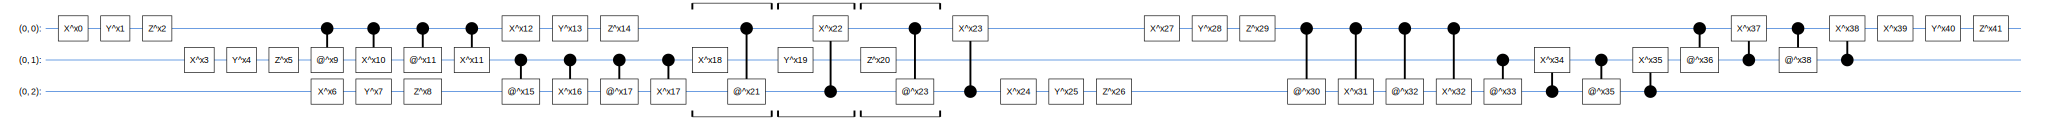

In [7]:

SVGCircuit(
    quantum_fc_circuit(cirq.GridQubit.rect(1, 3), sympy.symbols('x0:42'), Fcc = False))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


CZ 0 0 1
CX 0 0 1
Control on : 1
CZ 1 1 2
CX 1 1 2
Control on : 2
CZ 2 2 0
CX 2 2 0
Control on : 0


CZ 0 0 2
CX 0 0 2
Control on : 2
CZ 1 2 1
CX 1 2 1
Control on : 1
CZ 2 1 0
CX 2 1 0
Control on : 0
Number of params needed 33


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

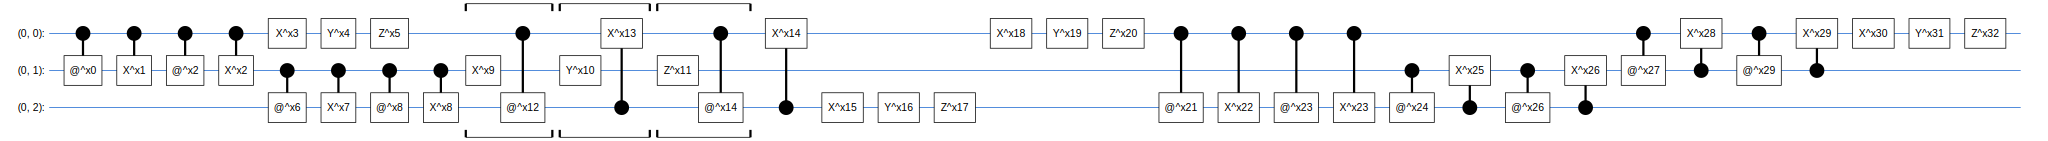

In [8]:
SVGCircuit(
    quantum_fc_circuit(cirq.GridQubit.rect(1, 3), sympy.symbols('x0:33'), Fcc = True))

## Create the model
Decide how many convulational layers, pooling etc....

In [9]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:78')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:3], qubits[3:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[3:], symbols[21:36])

    model_circuit += quantum_fc_circuit(qubits[3:], symbols[36:78], Fcc = False)
    
    #model_circuit += (cirq.r(symbols[36]) * cirq.Y(symbols[36])).controlled_by(qubits[5])
    
    #cirq.ControlledGate(cirq.rx(symbols[36]) * cirq.ry(symbols[37]) * cirq.rz(symbols[38])).on(qubits[4], qubits[5])
    #model_circuit += cirq.ControlledGate(my_U).on(qubits[4], qubits[5])
    #model_circuit += cirq.Circuit(custom_gate.on(*qubits[2:4]))
    #model_circuit += quantum_fc_circuit(qubits[3:], symbols[36:75])

    
    return model_circuit


from tensorflow_quantum import differentiators


qubits = cirq.GridQubit.rect(1, 6) #grid of qubit 
readout_operators = cirq.Z(qubits[-1]) #grid of operator i want to average on (final expected value)

# Build a sequential model enacting the logic in 1.3 of this notebook.
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string) #still general input

#define the differentiator
#differentiator = differentiators.ParameterShift()


#define the model 
quantum_model = tfq.layers.PQC(create_model_circuit(qubits),readout_operators)(inputs)

qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)


Number of params needed 42
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Load data of amplitude encoding

In [10]:
import json

# Open the file in read mode
with open('amplitude_encoding_train.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
train_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((5000))]

# Open the file in read mode
with open('amplitude_encoding_test.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
test_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((500))]

y_train = np.loadtxt("y_train.txt")
y_test = np.loadtxt("y_test.txt")

y_train = y_train[:5000]
y_test = y_test[:500]


In [11]:
# convert to tensors
train_circuits_data = tfq.convert_to_tensor(train_circuits_data)
test_circuits_data = tfq.convert_to_tensor(test_circuits_data)

In [12]:

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

In [13]:
history = qcnn_model.fit(x=train_circuits_data,
                         y=y_train,
                         batch_size=75,
                         epochs=50,
                         verbose=1,
                         validation_data=(test_circuits_data, y_test))

Epoch 1/50
67/67 [==============================] - 47s 695ms/step - loss: 0.8642 - custom_accuracy: 0.6688 - val_loss: 0.7570 - val_custom_accuracy: 0.8590
Epoch 2/50
67/67 [==============================] - 44s 656ms/step - loss: 0.6639 - custom_accuracy: 0.9060 - val_loss: 0.6416 - val_custom_accuracy: 0.8686
Epoch 3/50
67/67 [==============================] - 44s 663ms/step - loss: 0.5882 - custom_accuracy: 0.9302 - val_loss: 0.6133 - val_custom_accuracy: 0.9095
Epoch 4/50
67/67 [==============================] - 44s 664ms/step - loss: 0.5451 - custom_accuracy: 0.9492 - val_loss: 0.5650 - val_custom_accuracy: 0.9162
Epoch 5/50
67/67 [==============================] - 44s 658ms/step - loss: 0.5086 - custom_accuracy: 0.9566 - val_loss: 0.5383 - val_custom_accuracy: 0.9314
Epoch 6/50
67/67 [==============================] - 45s 679ms/step - loss: 0.4888 - custom_accuracy: 0.9580 - val_loss: 0.5243 - val_custom_accuracy: 0.9352
Epoch 7/50
67/67 [==============================] - 45s 67

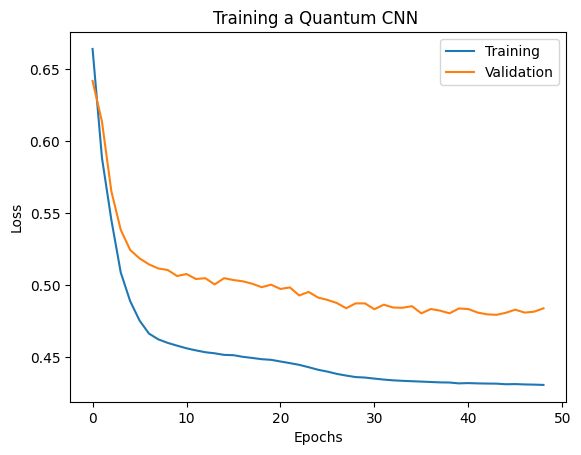

In [14]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

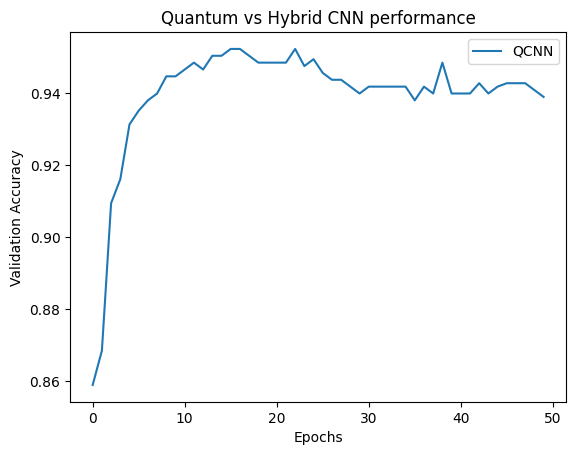

In [15]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [16]:
np.savetxt('nloss.txt', history.history['loss'][1:])
np.savetxt('nval_loss.txt', history.history['val_loss'][1:])

np.savetxt('nval_acc.txt', history.history['val_custom_accuracy'])